In [1]:
import numpy as np
import tensorflow as tf
import dicom as dm
import matplotlib.pyplot as plt

In [2]:
def change(arr):
    
    
    inti = arr[0]
    
    if inti == 0:
        inti = np.array([1, 0])
    else:
        inti = np.array([0, 1])
    
    inti = inti[np.newaxis, :] 
    
    for i in range(1, arr.shape[0]):
        
        tem = arr[i]
    
        if tem == 0:
            tem = np.array([1, 0])
        else:
            tem = np.array([0, 1])
        
        tem = tem[np.newaxis, :] 
    
        inti = np.append(inti, tem, axis = 0)
        
    return inti.astype(np.float32)
        
        
        


In [3]:
def read_and_decode():
    
    cwd = '/Users/wuzhenglin/Python_nice/SAL_LUNG/cancerANDhealthy_3.tfrecords'

    filename_queue = tf.train.string_input_producer([cwd]) 
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)   

    features = tf.parse_single_example(serialized_example,
                                       features={
                                               'label': tf.FixedLenFeature([], tf.int64),
                                               'img_raw' : tf.FixedLenFeature([], tf.string),
                                               }) 

    image = tf.decode_raw(features['img_raw'], tf.uint8)
    image = tf.reshape(image, [128, 128])
    label = tf.cast(features['label'], tf.int32)
    
    
    
    return image, label


In [4]:
def weight_variable(shape):
    
    initial = tf.truncated_normal(shape, stddev = 0.1, dtype = tf.float32)
    return tf.Variable(initial)


def bias_variable(shape):
    
    initial = tf.constant(0.1, shape = shape, dtype = tf.float32)
    return tf.Variable(initial)


def conv2d(x, W):
    
    #(input, filter, strides, padding)
    #[batch, height, width, in_channels]
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
    
    #(value, ksize, strides, padding)
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
  


In [15]:
def cnn_model():

    epochs = 1
    batch_size = 10
    learning_rate = 0.001
    hidden = 100
    cap_c = 498
    cap_h = 478
    num = cap_c + cap_h
    image_size = 128
    label_size = 2
    ex = 10
    
    
    
    
    train_loss = np.empty((num//(batch_size * ex)) * epochs + 5)
    train_acc = np.empty((num//(batch_size * ex)) * epochs + 5)

    x = tf.placeholder(tf.float32, shape = [None, image_size * image_size])
    y = tf.placeholder(tf.float32, shape = [None, label_size])
  
    X_train_ = tf.reshape(x, [-1, image_size, image_size, 1])

    #First layer
    W_conv1 = weight_variable([5, 5, 1, 32])
    b_conv1 = bias_variable([32])
      
    h_conv1 = tf.nn.relu(conv2d(X_train_, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    
    #Second layer
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])
    
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
    
    #Third layer
    #W_conv3 = weight_variable([5, 5, 64, 128])
    #b_conv3 = bias_variable([128])
    
    #h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
    #h_pool3 = max_pool_2x2(h_conv3)
    
    #Full connect layer
    W_fc1 = weight_variable([32 * 32 * 64, hidden])
    b_fc1 = bias_variable([hidden])

    h_pool2_flat = tf.reshape(h_pool2, [-1, 32 * 32 * 64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    
    #Output_Softmax
    
    W_fc2 = weight_variable([hidden, label_size])
    b_fc2 = bias_variable([label_size])
    
    y_conv = tf.nn.softmax(tf.matmul(h_fc1, W_fc2) + b_fc2)
    
    print y_conv.shape
    
#    y_conv = np.squeeze(y_conv)


    #Train
#    loss = tf.losses.sparse_softmax_cross_entropy(labels = y, logits = y_conv)
#    loss = -tf.reduce_sum(y * tf.log(y_conv))
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = y_conv))
    #cross_entropy = -tf.reduce_sum(y * tf.log(y_conv))
    optimize = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
#    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y, 1))
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y, 1)) 
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    

    
    
    print 'Begin training'
    #sess
    init_op = tf.initialize_all_variables()
   
    with tf.Session() as sess:
        
        sess.run(init_op)
        
        im, lab = read_and_decode()
    
    
    
        img_batch, label_batch = tf.train.shuffle_batch([im, lab],
                                                batch_size = batch_size, capacity = num,
                                                min_after_dequeue = 100)
        
        coord = tf.train.Coordinator()
        
        threads = tf.train.start_queue_runners(coord = coord)
        
        step = 1
        ex_s = 0
        
        for ep in range(epochs):
        
            for i in range(num//batch_size):
                
                example, l = sess.run([img_batch, label_batch])
                
                ll = change(l)
                
                example = example.flatten()
                example = example.reshape([batch_size, image_size * image_size])
                
    
                
                
                
                
                feed_dict = {x: example, y: ll}
                
                sess.run(optimize, feed_dict = feed_dict)
                
                los, acc = sess.run([loss, accuracy], feed_dict = feed_dict)
                p = sess.run([y_conv], feed_dict = feed_dict)
                #W1 = sess.run([W_conv1], feed_dict = feed_dict)
                
                if step < 6:
                    train_loss[ex_s] = los
                    train_acc[ex_s] = acc
                    ex_s = ex_s + 1
                    
                   
            
                    
                else:
                    if step % ex == 0:
                    
                        train_loss[ex_s] = los
                        train_acc[ex_s] = acc
                        ex_s = ex_s + 1
                        print "step: %d  loss: %.9f  accuracy: %.3f" % (step, los, acc)
            
                
                
                
                
                
                
                
                step = step + 1
                
                
            
        
        print 'Finish Train.'
        coord.request_stop()
        coord.join(threads)
        
        plt.subplot(211)
        plt.plot(train_loss, 'r')
        plt.xlabel("epochs")
        plt.ylabel("Training loss")
        plt.grid(True)

        plt.subplot(212)
        plt.plot(train_acc, 'r')
        plt.xlabel("epochs")
        plt.ylabel('Training Accuracy')
        #plt.ylim(0.0, 1)
        plt.grid(True)
        plt.show()
 
               


(?, 2)
Begin training
Instructions for updating:
Use `tf.global_variables_initializer` instead.
step: 10  loss: 0.713261604  accuracy: 0.600
step: 20  loss: 1.113261580  accuracy: 0.200
step: 30  loss: 1.213261604  accuracy: 0.100
step: 40  loss: 0.713261604  accuracy: 0.600
step: 50  loss: 1.113261580  accuracy: 0.200
step: 60  loss: 0.913261592  accuracy: 0.400
step: 70  loss: 1.013261557  accuracy: 0.300
step: 80  loss: 1.013261557  accuracy: 0.300
step: 90  loss: 0.613261640  accuracy: 0.700
Finish Train.


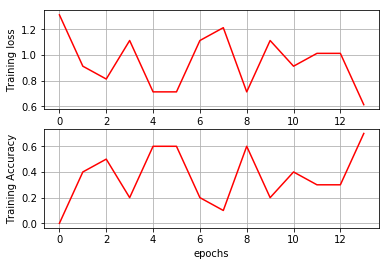

In [20]:
cnn_model()